<CENTER>
    
# MEGALINE

A empresa de telecomunicações, Megaline, oferece aos clientes dois planos pré-pagos: **Surf e Ultimate**.  
O departamento comercial deseja saber qual dos planos gera mais receita para ajustar o orçamento de publicidade.

Iremos realizar uma análise preliminar dos planos com base em dados de 500 clientes: de onde são, qual plano usam e o número de chamadas e mensagens realizadas em 2018. 

**OBSERVAÇÕES IMPORTANTES:**   

* A Megaline arredonda segundos para minutos e megabytes para gigabytes.   


* Para chamadas, cada chamada individual é arredondada para cima: mesmo que uma chamada tenha durado apenas um segundo, um minuto será contado.   


* Para tráfego da web, sessões individuais da web não são arredondadas para cima. Ao invés disso, o total do mês é arredondado para cima. Se alguém usar 1.025 megabytes no mês, a cobrança será de 2 gigabytes.

## OBJETIVO   

**O objetivo deste projeto é analisar o comportamento dos clientes e determinar qual plano pré-pago gera mais receita.**

## IMPORTAÇÃO DAS BIBLIOTECAS

In [1]:
### Carregando todas as bibliotecas
import pandas as pd
import numpy as np
from scipy import stats as st
import math as mt
import seaborn as sns
from matplotlib import pyplot as plt

## CARREGAMENTO E PREPARAÇÃO DOS DADOS

Os dados deste projeto estão divididos em várias tabelas (calls, internet, messages, plans e users). Exploraremos cada uma delas para obter uma compreensão inicial dos dados e faremos correções em cada tabela, se necessário.

In [2]:
# Carregue os arquivos de dados em diferentes DataFrames
calls = pd.read_csv('/datasets/megaline_calls.csv')
internet = pd.read_csv('/datasets/megaline_internet.csv')
messages = pd.read_csv('/datasets/megaline_messages.csv')
plans = pd.read_csv('/datasets/megaline_plans.csv')
users = pd.read_csv('/datasets/megaline_users.csv')

### Tabela Planos

In [3]:
print(plans.head())
print()
plans.info()

   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0               20          10             0.03            0.03      surf  
1               70           7             0.01            0.01  ultimate  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   pl

O DataFrame tem somente 2 linhas que descrevem as informações dos planos e não possuem dados ausentes. O único ponto a ser alterado nesses dados é transformar os tipos de dados das colunas que envolvem valores financeiros para 'float' e a coluna 'plan_name' para o tipo de dados de categoria.

#### Correção dos dados

In [4]:
plans['usd_monthly_pay'] = plans['usd_monthly_pay'].astype('float')
plans['usd_per_gb'] = plans['usd_per_gb'].astype('float')
plans['plan_name'] = plans['plan_name'].astype('category')

plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   messages_included      2 non-null      int64   
 1   mb_per_month_included  2 non-null      int64   
 2   minutes_included       2 non-null      int64   
 3   usd_monthly_pay        2 non-null      float64 
 4   usd_per_gb             2 non-null      float64 
 5   usd_per_message        2 non-null      float64 
 6   usd_per_minute         2 non-null      float64 
 7   plan_name              2 non-null      category
dtypes: category(1), float64(4), int64(3)
memory usage: 366.0 bytes


### Tabela Usuários

In [5]:
# Imprima as informações gerais/resumidas sobre o DataFrame dos usuários
users.info()
print()
print(users.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB

   user_id first_name  last_name  age                                   city  \
0     1000   Anamaria      Bauer   45  Atlanta-Sandy Springs-Roswell, GA MSA   
1     1001     Mickey  Wilkerson   28        Seattle-Tacoma-Bellevue, WA MSA   
2     1002     Carlee    Hoffman   36   Las Vegas-Henderson-Paradise, NV MSA   
3     1003   Reynaldo    Jenkins   52                          Tulsa, OK MSA   
4     1004    Leonila   Thompson   40       

O DataFrame não apresenta dados ausentes (apresenta somente na coluna churn_date, porém isso já é esperado e significa que o plano estava em uso quando o banco de dados foi extraído, portanto não existe uma data de cancelamento).

Temos alguns problemas quanto aos tipos de dados: 
- a coluna 'user_id' deve ser tratada como objeto, pois não há necessidade de operações com um id de usuário;
- As colunas 'reg_date' e 'churn_date' devem ser do tipo data e não objeto;
- A coluna 'plans' deve ser do tipo de categoria, pois representa um conjunto de categorias, além de economizar memória.

Uma forma de melhorar os dados é separar os nomes das cidades dos estados, criando uma nova coluna somente com os estados.

#### Correção dos dados

In [6]:
users['user_id'] = users['user_id'].astype('object')
users['reg_date'] = pd.to_datetime(users['reg_date'], format = '%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format = '%Y-%m-%d')
users['plan'] = users['plan'].astype('category')

print(users.head(5))
print()
users.info()

  user_id first_name  last_name  age                                   city  \
0    1000   Anamaria      Bauer   45  Atlanta-Sandy Springs-Roswell, GA MSA   
1    1001     Mickey  Wilkerson   28        Seattle-Tacoma-Bellevue, WA MSA   
2    1002     Carlee    Hoffman   36   Las Vegas-Henderson-Paradise, NV MSA   
3    1003   Reynaldo    Jenkins   52                          Tulsa, OK MSA   
4    1004    Leonila   Thompson   40        Seattle-Tacoma-Bellevue, WA MSA   

    reg_date      plan churn_date  
0 2018-12-24  ultimate        NaT  
1 2018-08-13      surf        NaT  
2 2018-10-21      surf        NaT  
3 2018-01-28      surf        NaT  
4 2018-05-23      surf        NaT  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    object        
 1   first_name  500 non-null    object        
 2   last_na

#### Enriquecimento dos dados

Vamos separar os nomes das cidades dos estados, criando uma nova coluna somente com os estados para facilitar futuras filtragens

In [7]:
users[['cidade', 'estado']] = users['city'].str.split(',', expand = True)
users['estado'] = users['estado'].str.strip() #retirando os espaços desnecessários após separação dos nomes das cidades

states = users['estado'].sort_values(ascending=True)
print(states.unique()) #verificando alguma possível duplicidade

['AL MSA' 'AZ MSA' 'CA MSA' 'CO MSA' 'CT MSA' 'DC-VA-MD-WV MSA' 'FL MSA'
 'GA MSA' 'HI MSA' 'IL-IN-WI MSA' 'IN MSA' 'KY-IN MSA' 'LA MSA'
 'MA-NH MSA' 'MD MSA' 'MI MSA' 'MN-WI MSA' 'MO-IL MSA' 'MO-KS MSA'
 'NC MSA' 'NC-SC MSA' 'NE-IA MSA' 'NM MSA' 'NV MSA' 'NY MSA'
 'NY-NJ-PA MSA' 'OH MSA' 'OH-KY-IN MSA' 'OK MSA' 'OR-WA MSA' 'PA MSA'
 'PA-NJ-DE-MD MSA' 'RI-MA MSA' 'SC MSA' 'TN MSA' 'TN-MS-AR MSA' 'TX MSA'
 'UT MSA' 'VA MSA' 'VA-NC MSA' 'WA MSA' 'WI MSA']


### Tabela Chamadas

In [8]:
print(calls.sample(5))
print()
calls.info()

              id  user_id   call_date  duration
121602  1427_270     1427  2018-11-02      8.68
90460    1328_90     1328  2018-06-24      9.57
25615   1098_305     1098  2018-11-05      5.82
61395    1222_42     1222  2018-09-25     12.66
6088    1029_252     1029  2018-11-19      2.23

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


O DataFrame calls não apresenta dados ausentes em nenhuma coluna, porém temos alguns problemas de tipos de dados, como:
- A coluna 'user_id' deve ser convertida para o tipo object;
- A coluna 'call_date' deve ser convertida para o tipo datetime64;

#### Correção dos dados

In [9]:
calls['user_id'] = calls['user_id'].astype('object')
calls['call_date'] = pd.to_datetime(calls['call_date'], format = '%Y-%m-%d')
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  object        
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 4.2+ MB


#### Enriquecimento dos dados

Com base na informação de que cada chamada individual é arredondada para cima (mesmo que uma chamada tenha durado apenas um segundo, um minuto será contado), vamos criar uma coluna com a duração das chamadas arredondadas, pois isto nos será útil nas análises.  

Também criaremos uma coluna somente com o mês da ligação.

In [10]:
# Criando a coluna com duração arredondada da chamada
calls['duration_rounded'] = calls['duration'].apply(lambda x: mt.ceil(x))
calls['duration_rounded'] = calls['duration_rounded'].astype('int')

# criando a coluna com o mês da chamada para agrupamento posterior
calls['call_month'] = calls['call_date'].dt.month

print(calls.sample(5))

              id user_id  call_date  duration  duration_rounded  call_month
70787   1252_116    1252 2018-12-08      0.00                 0          12
50298   1181_665    1181 2018-06-11      3.41                 4           6
17619   1067_167    1067 2018-12-06      0.00                 0          12
56239   1201_339    1201 2018-06-05     18.42                19           6
122716  1433_287    1433 2018-11-09      0.00                 0          11


### Tabela Mensagens

In [11]:
print(messages.sample(5))
print()
messages.info()

             id  user_id message_date
57136  1362_207     1362   2018-10-09
19370   1125_38     1125   2018-12-15
56599  1357_294     1357   2018-07-20
44359  1294_140     1294   2018-10-04
34706  1220_224     1220   2018-05-14

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


O DataFrame messages não apresenta dados ausentes em nenhuma coluna, porém temos alguns problemas de tipos de dados, como:
- A coluna 'user_id' deve ser convertida para o tipo object;
- A coluna 'message_date' deve ser convertida para o tipo datetime64;

#### Correção dos dados

In [12]:
messages['user_id'] = messages['user_id'].astype('object')
messages['message_date'] = pd.to_datetime(messages['message_date'], format = '%Y-%m-%d')
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  object        
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ MB


#### Enriquecimento dos dados

Vamos criar uma coluna somente com o mês do envio da mensagem 

In [13]:
messages['message_month'] = messages['message_date'].dt.month
print(messages.sample(5))

              id user_id message_date  message_month
12934   1084_174    1084   2018-10-28             10
49210   1328_168    1328   2018-11-27             11
21799  1132_1290    1132   2018-07-09              7
15799    1104_37    1104   2018-12-30             12
12785    1084_25    1084   2018-10-26             10


### Tabela Internet

In [14]:
print(internet.sample(5))
print()
internet.info()

             id  user_id session_date  mb_used
15968  1072_332     1072   2018-11-16   181.95
63699  1292_403     1292   2018-08-25   566.83
60005  1270_175     1270   2018-12-22   534.34
15846   1072_85     1072   2018-11-30   320.39
80749  1377_174     1377   2018-09-11   333.84

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


O DataFrame internet não apresenta dados ausentes em nenhuma coluna, porém temos alguns problemas de tipos de dados, como:

- A coluna 'user_id' deve ser convertida para o tipo object;
- A coluna 'session_date' deve ser convertida para o tipo datetime64;

#### Correção dos dados

In [15]:
internet['user_id'] = internet['user_id'].astype('object')
internet['session_date'] = pd.to_datetime(internet['session_date'], format = '%Y-%m-%d')
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  object        
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 3.2+ MB


#### Enriquecimento dos dados

Conforme a informação de que para tráfego da web, sessões individuais da web não são arredondadas para cima. 
Porém, o total do mês é arredondado para cima. Iremos criar uma coluna com somente o mês da sessão

In [16]:
internet['session_month'] = internet['session_date'].dt.month
print(internet.sample(5))

             id user_id session_date  mb_used  session_month
52117   1234_38    1234   2018-12-31     0.00             12
79608  1371_357    1371   2018-11-25     0.00             11
94990   1443_60    1443   2018-11-26   914.08             11
54223  1246_124    1246   2018-08-07     0.00              8
95833   1447_23    1447   2018-11-05   236.29             11


## ESTUDO DAS CONDIÇÕES DOS PLANOS

In [17]:
# Imprimindo as condições dos planos para análise
print(plans.head())

   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0             20.0        10.0             0.03            0.03      surf  
1             70.0         7.0             0.01            0.01  ultimate  


### Agregação dos dados por usuário

Nesta etapa iremos agregar os resultados por usuário por mês para calcular:

* Número de chamadas feitas por cada usuário por mês;

* Quantidade de minutos gastos por cada usuário por mês;

* Número de mensagens enviadas por cada usuário por mês;

* Volume de tráfego de internet usado por cada usuário por mês

In [18]:
# Calculando o número de chamadas feitas por cada usuário por mês
calls_per_user = calls.merge(users, on= 'user_id')
calls_per_user = calls_per_user.groupby(['user_id', 'call_month'])['id'].count()
print(calls_per_user.head(5))

user_id  call_month
1000     12            16
1001     8             27
         9             49
         10            65
         11            64
Name: id, dtype: int64


In [19]:
# Calculando a quantidade de minutos gastos por cada usuário por mês.
minutes_per_user = calls.merge(users, on= 'user_id')
minutes_per_user = minutes_per_user.groupby(['user_id', 'call_month'])['duration_rounded'].sum()
print(minutes_per_user.head(5))

user_id  call_month
1000     12            124
1001     8             182
         9             315
         10            393
         11            426
Name: duration_rounded, dtype: int64


In [20]:
# Calculando o número de mensagens enviadas por cada usuário por mês
messages_per_user = messages.merge(users, on= 'user_id')
messages_per_user = messages_per_user.groupby(['user_id', 'message_month'])['id'].count()
print(messages_per_user.head(5))

user_id  message_month
1000     12               11
1001     8                30
         9                44
         10               53
         11               36
Name: id, dtype: int64


In [21]:
# Calculando o volume de tráfego de internet usado por cada usuário por mês
mb_used_per_user = internet.merge(users, on= 'user_id')
mb_used_per_user = mb_used_per_user.groupby(['user_id', 'session_month'])['mb_used'].sum()
print(mb_used_per_user.head(5))

user_id  session_month
1000     12                1901.47
1001     8                 6919.15
         9                13314.82
         10               22330.49
         11               18504.30
Name: mb_used, dtype: float64


### Agora vamos concatenar todos esses dados em um DataFrame

In [22]:
# Concatenando os dados de chamadas, minutos, mensagens e internet com base em user_id e month
df_concat = pd.concat([calls_per_user, minutes_per_user, messages_per_user, mb_used_per_user], axis = 'columns')
df_concat = df_concat.reset_index()

df_concat.columns = ['user_id', 'month', 'calls', 'minutes', 'messages', 'mb_used']
columns_to_replace = ['calls', 'minutes', 'messages', 'mb_used']

for col in columns_to_replace:
    df_concat[col].fillna(0, inplace = True)

# Criando uma coluna com a quantidade arredondada de mb de internet consumida
# Somando 0.99 para converter os dados para int, mas sempre arredondando para cima
df_concat['mb_rounded'] = df_concat['mb_used'] + 0.99
df_concat['mb_rounded'] = df_concat['mb_rounded'].astype('int')

# Convertendo todas as outras colunas para 'int'
df_concat['calls'] = df_concat['calls'].astype('int')
df_concat['minutes'] = df_concat['minutes'].astype('int')
df_concat['messages'] = df_concat['messages'].astype('int')

# Removendo a coluna 'mb_used', pois criamos uma coluna 'mb_rounded' já com valores arredondados
df_concat = df_concat.drop('mb_used', axis = 'columns')

print(df_concat.head())

   user_id  month  calls  minutes  messages  mb_rounded
0     1000     12     16      124        11        1902
1     1001      8     27      182        30        6920
2     1001      9     49      315        44       13315
3     1001     10     65      393        53       22331
4     1001     11     64      426        36       18505


### Agora vamos adicionar a este DataFrame as informações sobre os usuários e os planos

In [23]:
df_concat_plan = df_concat.merge(users, on= 'user_id')

df_complete = df_concat_plan.merge(plans, left_on= 'plan', right_on = 'plan_name')
df_complete = df_complete.drop('plan', axis = 'columns')

print(df_complete.sample(3))

     user_id  month  calls  minutes  messages  mb_rounded first_name  \
785     1022      9     66      510         0       14119         Bo   
105     1061      8     87      595        71       18425     Maryam   
1171    1138      9     54      374        17       20714      Arlie   

     last_name  age                                       city  ...  \
785       Snow   73  New York-Newark-Jersey City, NY-NJ-PA MSA  ...   
105   Valencia   38                           Columbia, SC MSA  ...   
1171   Higgins   66   Riverside-San Bernardino-Ontario, CA MSA  ...   

                                cidade        estado messages_included  \
785        New York-Newark-Jersey City  NY-NJ-PA MSA                50   
105                           Columbia        SC MSA              1000   
1171  Riverside-San Bernardino-Ontario        CA MSA                50   

     mb_per_month_included  minutes_included  usd_monthly_pay  usd_per_gb  \
785                  15360               500        

### Vamos calcular a receita mensal para cada usuário

In [24]:
# Calculando e criando colunas com as informações de minutos, mensagens e gb extras consumidos pelos usuários 
df_complete['ext_min'] = ((df_complete['minutes'] - df_complete['minutes_included']) *  df_complete['usd_per_minute'])
df_complete['ext_messages'] = ((df_complete['messages'] - df_complete['messages_included']) *  df_complete['usd_per_message']) 
df_complete['ext_gb'] = ((df_complete['mb_rounded'] - df_complete['mb_per_month_included'])/1000 *  df_complete['usd_per_gb'])

# Usando where para substituir resultados negativos por 0
df_complete['ext_min'] = df_complete['ext_min'].where(df_complete['ext_min'] > 0, 0)
df_complete['ext_messages'] = df_complete['ext_messages'].where(df_complete['ext_messages'] > 0, 0)
df_complete['ext_gb'] = df_complete['ext_gb'].where(df_complete['ext_gb'] > 0, 0)

# Calculando a receita mensal por usuário
df_complete['monthly_income'] = df_complete['usd_monthly_pay'] + df_complete['ext_min'] + df_complete['ext_messages'] + df_complete['ext_gb']

print(df_complete['monthly_income'].sample(5))

192     70.00
517     70.00
8       70.00
1097    20.00
968     47.78
Name: monthly_income, dtype: float64


## ESTUDO DO COMPORTAMENTO DO USUÁRIO

Nesta etapa iremos realizar o estudo do comportamento dos usuários realizando uma série de comparações entre médias e somatórios dos planos em questão.  

Para isso, criaremos 2 funções (uma para comparação de médias e uma para comparação de somatórios), depois chamaremos essas funções para obtermos os resultados nas variáveis desejadas e plotaremos gráficos de barras, histogramas e boxplots para facilitar a visualização dos resultados.

In [25]:
# Criando a função de comparação de médias
def comparison_mean(df, column):
    
    # Vamos agrupar por nome do plano e mês. Depois calcular a média da coluna desejada
    parcial_mean = df.groupby(['plan_name', 'month'])[column].mean()
    parcial_mean = parcial_mean.reset_index()
    
    # Vamos filtrar, separando os dados do plano surf e do plano ultimate
    surf = parcial_mean[parcial_mean['plan_name'] == 'surf']
    ultimate = parcial_mean[parcial_mean['plan_name'] == 'ultimate']
    
    # Vamos fazer o merge dos dataframes filtrados e definir a coluna 'month' como índice
    df_mean_merge = surf.merge(ultimate, on = 'month', suffixes= ['_surf', '_ultimate'])
    df_mean_merge = df_mean_merge.drop(['plan_name_surf', 'plan_name_ultimate'], axis='columns')
    df_mean_merge = df_mean_merge.set_index('month')
    
    # Vamos retornar o df após merge. Pronto para a plotagem dos gráficos necessários
    return df_mean_merge

In [26]:
# Criando a função de comparação de somatórios
def comparison_sum(df, column):
    
    # Vamos agrupar por nome do plano e mês. Depois calcular a somatória da coluna desejada
    parcial_mean = df.groupby(['plan_name', 'month'])[column].sum()
    parcial_mean = parcial_mean.reset_index()
    
    # Vamos filtrar, separando os dados do plano surf e do plano ultimate
    surf = parcial_mean[parcial_mean['plan_name'] == 'surf']
    ultimate = parcial_mean[parcial_mean['plan_name'] == 'ultimate']
    
    # Vamos fazer o merge dos dataframes filtrados e definir a coluna 'month' como índice
    df_mean_merge = surf.merge(ultimate, on = 'month', suffixes= ['_surf', '_ultimate'])
    df_mean_merge = df_mean_merge.drop(['plan_name_surf', 'plan_name_ultimate'], axis='columns')
    df_mean_merge = df_mean_merge.set_index('month')
    
    # Vamos retornar o df após merge. Pronto para a plotagem dos gráficos necessários
    return df_mean_merge

### Chamadas

#### Comparação da duração média das chamadas de cada plano para cada mês

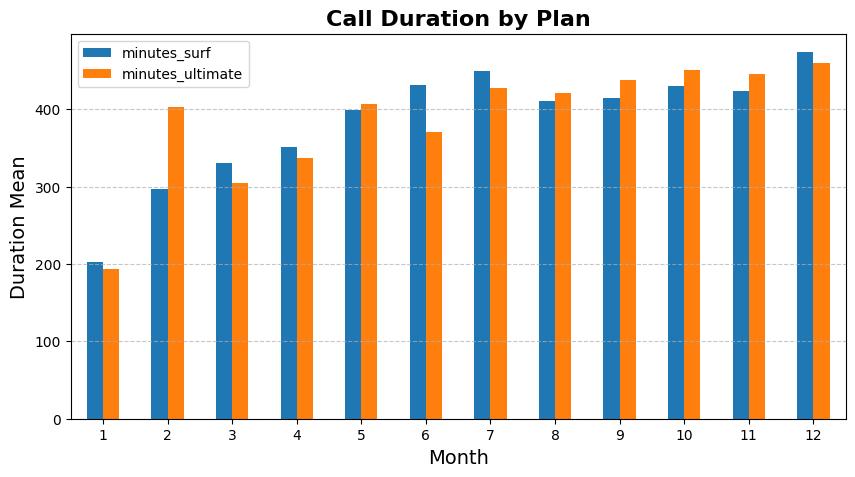

In [27]:
# Chamando a função comparison_mean para a coluna 'minutes'
call_duration_mean = comparison_mean(df_complete, 'minutes')

# Plotando o gráfico 
call_duration_mean.plot(kind = 'bar',
                        title = 'CALL DURATION BY PLAN',
                        figsize = [10, 5],
                        color = ['#1f77b4', '#ff7f0e'],
                        rot = 0
                       )

plt.title('Call Duration by Plan', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=14)
plt.ylabel('Duration Mean', fontsize=14)

# Adicionar grade para melhorar a leitura
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adicionar legenda, se aplicável
plt.legend(fontsize=10, title_fontsize='10')

plt.show()

#### Comparação do número de minutos extras de que os usuários de cada plano necessitam a cada mês

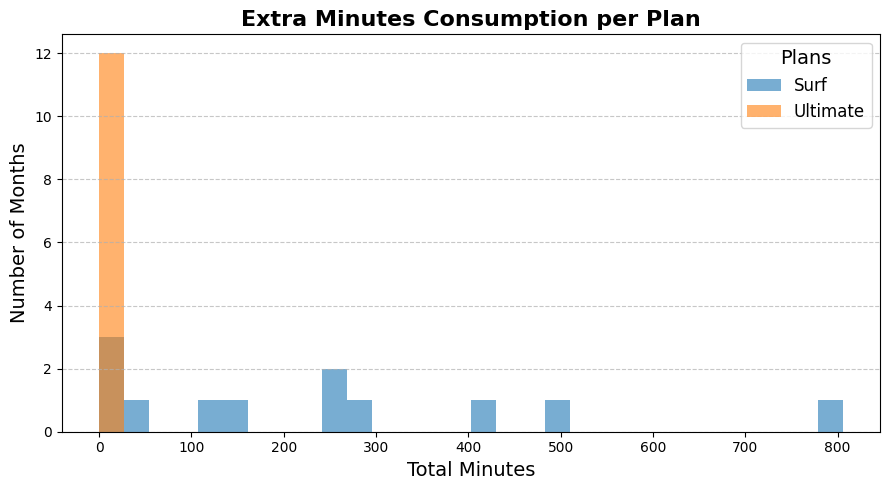

In [28]:
# Chamando a função comparison_sum para obter o somatório de 'ext_min' dos usuários de cada plano
call_ext_minutes_merge = comparison_sum(df_complete, 'ext_min')

# Plotando o histograma para comparação dos minutos extras de cada plano
call_ext_minutes_merge.plot(kind='hist', bins=30, alpha=0.6, color=['#1f77b4', '#ff7f0e'], figsize=[9,5])

plt.title('Extra Minutes Consumption per Plan', fontsize=16, fontweight='bold')
plt.xlabel('Total Minutes', fontsize=14)
plt.ylabel('Number of Months', fontsize=14)
plt.legend(['Surf', 'Ultimate'], title='Plans', fontsize=12, title_fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

#### Agora vamos calcular a média e a variação da duração mensal das chamadas

In [29]:
surf_variance = np.var(call_duration_mean['minutes_surf'])
ultimate_variance = np.var(call_duration_mean['minutes_ultimate'])

print('Média em minutos do plano surf:', call_duration_mean['minutes_surf'].mean())
print('Variância do plano surf:', surf_variance)
print()
print('Média em minutos do plano ultimate:', call_duration_mean['minutes_ultimate'].mean())
print('Variância do plano ultimate:', ultimate_variance)

Média em minutos do plano surf: 384.4696912581946
Variância do plano surf: 5369.551951906404

Média em minutos do plano ultimate: 387.99974229608006
Variância do plano ultimate: 5472.540903753354


#### Vamos plotar um diagrama de caixa para visualizar a distribuição da duração mensal das chamadas

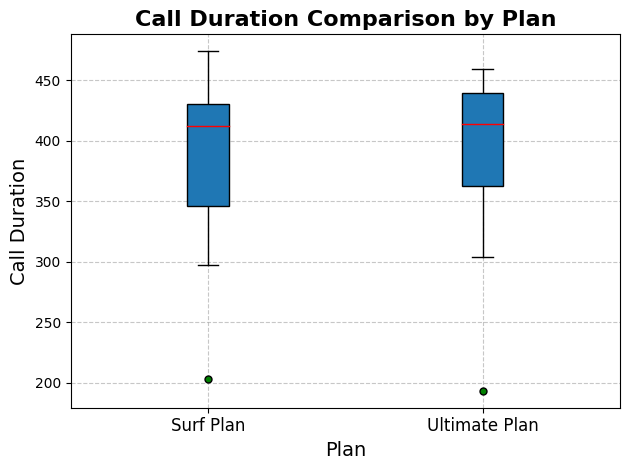

minutes_surf        412.168958
minutes_ultimate    413.839000
dtype: float64


In [30]:
call_duration_mean.boxplot(column=['minutes_surf', 'minutes_ultimate'],
                           grid=True,
                           patch_artist=True,
                           boxprops=dict(facecolor='#1f77b4', color='black'),
                           medianprops=dict(color='red'),
                           whiskerprops=dict(color='black'),
                           capprops=dict(color='black'),
                           flierprops=dict(markerfacecolor='green', marker='o', markersize=5, linestyle='none'))


plt.title('Call Duration Comparison by Plan', fontsize=16, fontweight='bold')
plt.xlabel('Plan', fontsize=14)
plt.ylabel('Call Duration', fontsize=14)
plt.xticks([1, 2], ['Surf Plan', 'Ultimate Plan'], fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

print(call_duration_mean.median())

#### CONCLUSÕES

-  O comportamento dos usuários não se altera com o plano, pois podemos observar que a média da duração das chamadas é bem parecida mês a mês para os dois planos, além também da média geral de duração das chamadas (anual).  


- Isso fica ainda mais evidente quando olhamos para o boxplot, pois podemos observar que o valor da mediana também é praticamente igual.  


- O que podemos observar de diferença entre os usuários é que os usuários do plano 'ultimate' não necessitam de minutos extras, enquanto que os usuários do plano 'surf' precisam, pois o plano contempla menos minutos.

### Mensagens

#### Vamos comparar a média de mensagens para cada plano por mês

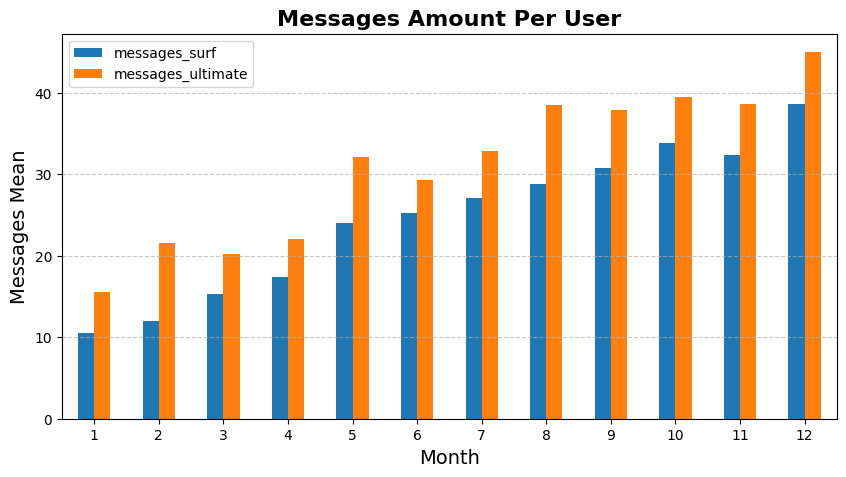

In [31]:
# Chamando a função comparison_mean para a coluna 'messages'
messages_per_plan = comparison_mean(df_complete, 'messages')

# criando gráfico para comparação
messages_per_plan.plot(kind = 'bar',
                    figsize = [10, 5],
                    color = ['#1f77b4', '#ff7f0e'],
                    rot= 0)


plt.title('Messages Amount Per User', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=14)
plt.ylabel('Messages Mean', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=10, title_fontsize='10')

plt.show()

#### Vamos comparar o número de mensagens extras de que os usuários de cada plano necessitam a cada mês

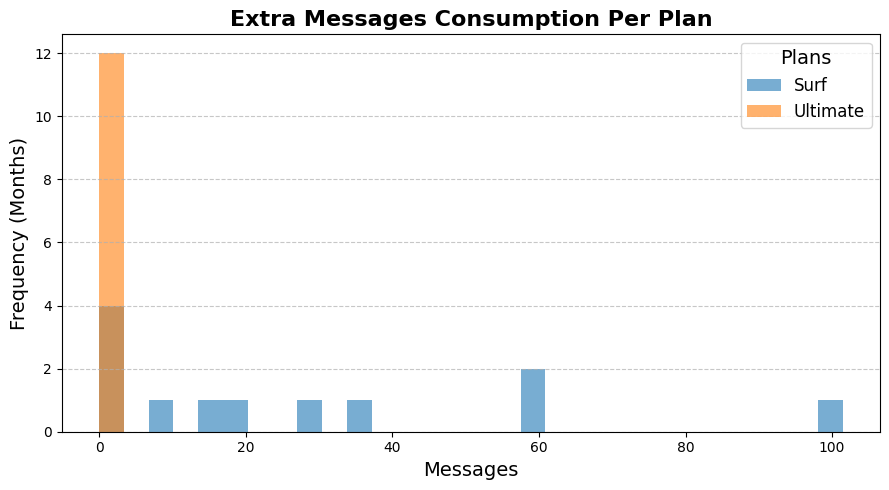

In [32]:
# Chamando a função comparison_sum para 'extra_messages'
ext_messages_per_user = comparison_sum(df_complete, 'ext_messages')

# Plotando o histograma para comparação
ext_messages_per_user.plot(kind='hist', bins=30, alpha=0.6, color=['#1f77b4', '#ff7f0e'], figsize=[9,5])

plt.title('Extra Messages Consumption Per Plan', fontsize=16, fontweight='bold')
plt.xlabel('Messages',fontsize=14)
plt.ylabel('Frequency (Months)', fontsize=14)
plt.legend(['Surf', 'Ultimate'], title='Plans', fontsize=12, title_fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

#### Vamos plotar um diagrama de caixa para visualizar a distribuição mensal das mensagens

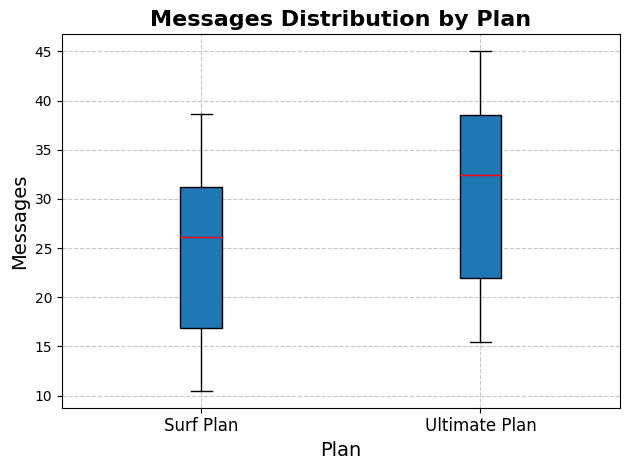

messages_surf        26.166013
messages_ultimate    32.466978
dtype: float64


In [33]:
messages_per_plan.boxplot(column=['messages_surf', 'messages_ultimate'],
                           grid=True,
                           patch_artist=True,
                           boxprops=dict(facecolor='#1f77b4', color='black'),
                           medianprops=dict(color='red'),
                           whiskerprops=dict(color='black'),
                           capprops=dict(color='black'),
                           flierprops=dict(markerfacecolor='green', marker='o', markersize=5, linestyle='none'))


plt.title('Messages Distribution by Plan', fontsize=16, fontweight='bold')
plt.xlabel('Plan', fontsize=14)
plt.ylabel('Messages', fontsize=14)
plt.xticks([1, 2], ['Surf Plan', 'Ultimate Plan'], fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()


print(messages_per_plan.median())

#### CONCLUSÕES

- Analisando o gráfico de médias mensais de envio de mensagens é possível inferir que os usuários do plano ' ultimate' tendem a enviar mais mensagens do que os usuários do plano 'surf'. Isso também pode ser confirmado observando o gráfico boxplot;  


- Quando analisamos o histograma de mensagens extras que os usuários necessita, podemos identificar que os usuários do plano 'ultimate' não realizam envio de mensagens além da quantidade prevista no pacote, enquanto que usuários do plano 'surf' necessitam desta utilização.

### Internet

#### Comparação da quantidade de tráfego de internet consumido pelos usuários por plano

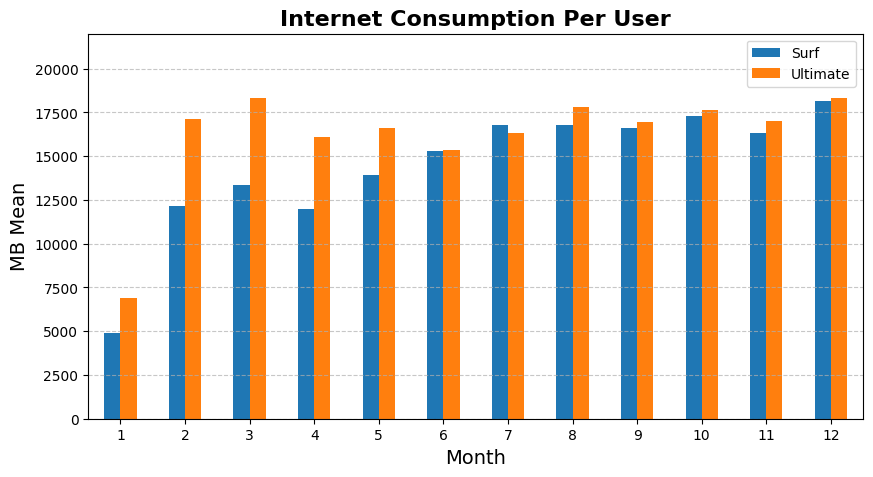

In [34]:
internet_per_plan = comparison_mean(df_complete, 'mb_rounded')

internet_per_plan.plot(kind = 'bar',
                    figsize = [10, 5],
                    color = ['#1f77b4', '#ff7f0e'],
                    ylim = [0, 22000],
                    rot= 0)

plt.title('Internet Consumption Per User', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=14)
plt.ylabel('MB Mean', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(['Surf', 'Ultimate'], fontsize=10, title_fontsize='10')

plt.show()

#### Comparação da quantidade de mb extras de que os usuários de cada plano necessitam a cada mês

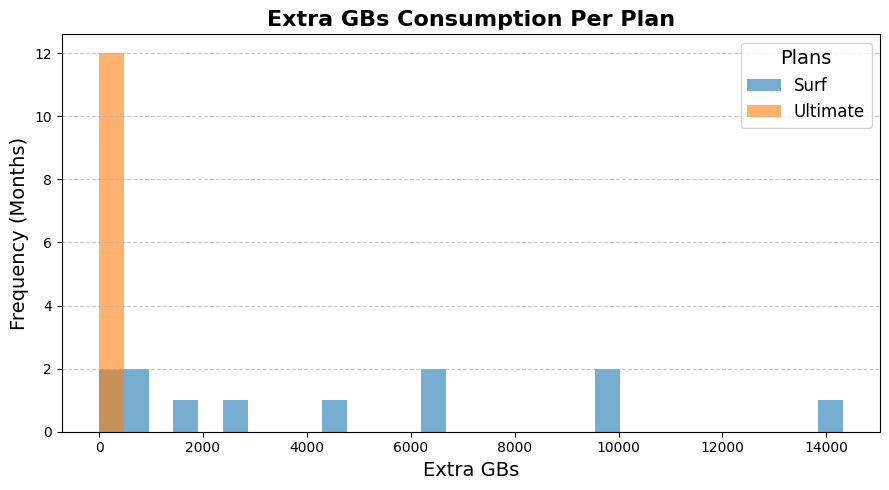

In [35]:
# Chamando a função 'comparison_sum' para a coluna 'ext_gb'
ext_gb_per_user = comparison_sum(df_complete, 'ext_gb')

# plotando o histograma
ext_gb_per_user.plot(kind='hist', bins=30, alpha=0.6, color=['#1f77b4', '#ff7f0e'], figsize=[9,5])

plt.title('Extra GBs Consumption Per Plan', fontsize=16, fontweight='bold')
plt.xlabel('Extra GBs',fontsize=14)
plt.ylabel('Frequency (Months)', fontsize=14)
plt.legend(['Surf', 'Ultimate'], title='Plans', fontsize=12, title_fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

#### Vamos plotar um diagrama de caixa para visualizar a distribuição de consumo mensal de internet

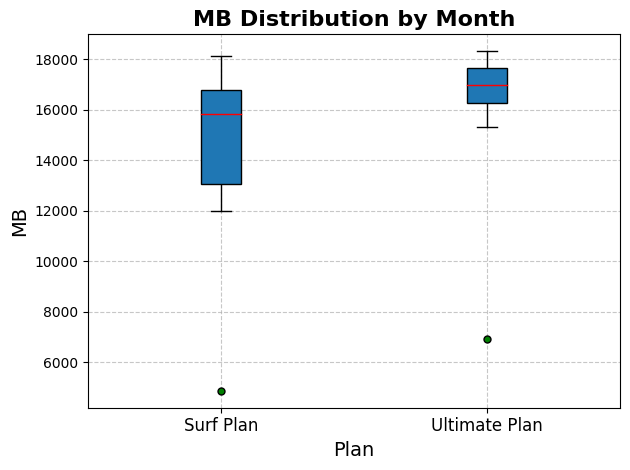

mb_rounded_surf        15820.865870
mb_rounded_ultimate    17002.270784
dtype: float64


In [36]:
internet_per_plan.boxplot(column=['mb_rounded_surf', 'mb_rounded_ultimate'],
                           grid=True,
                           patch_artist=True,
                           boxprops=dict(facecolor='#1f77b4', color='black'),
                           medianprops=dict(color='red'),
                           whiskerprops=dict(color='black'),
                           capprops=dict(color='black'),
                           flierprops=dict(markerfacecolor='green', marker='o', markersize=5, linestyle='none'))

plt.title('MB Distribution by Month', fontsize=16, fontweight='bold')
plt.xlabel('Plan', fontsize=14)
plt.ylabel('MB', fontsize=14)
plt.xticks([1, 2], ['Surf Plan', 'Ultimate Plan'], fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()


print(internet_per_plan.median())

#### CONCLUSÕES

- **Analisando o gráfico de barras** referente às médias mensais do consumo de dados, podemos observar que os usuários do plano ' ultimate' tiveram um consumo superior ao dos usuários do plano 'surf' durante os 5 primeiros meses do ano. A partir do sexto mês, este consumo praticamente se igualou entre os usuários dos dois planos; Podemos observar no boxplot que a variação dos dados do plano 'ultimate' é menor, pois o consumo dos usuários deste plano se manteve mais estável durante o ano, enquanto que o consumo dos usuários do plano 'surf' eram baixos no início do ano e depois se igualaram ao do plano 'ultimate' e, por este motivo, o boxplot apresenta maior variação.  


- **Analisando o histograma** de consumo de dados extras, podemos observar que a necessidade do consumo de dados extras é muito maior entre os usuários do plano 'surf'. Os usuários do plano 'ultimate', apesar de fazerem uso de dados extras (diferentemente do observado quando analisamos minutos e mensagens extras), necessitam muito menos do que os usuários do outro plano. 

## RECEITA

### Vamos plotar um gráfico de barras comparando a receita de cada plano mês a mês

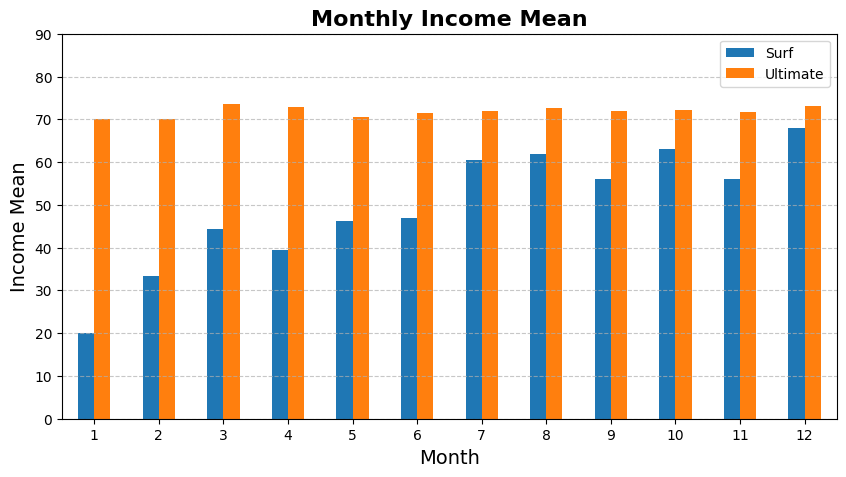

In [37]:
# Chamando a função comparison_mean
income_mean_by_plan = comparison_mean(df_complete, 'monthly_income')

# plotando o gráfico
income_mean_by_plan.plot(kind = 'bar',
                    figsize = [10, 5],
                    color = ['#1f77b4', '#ff7f0e'],
                    ylim = [0, 90],
                    rot= 0)

plt.title('Monthly Income Mean', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=14)
plt.ylabel('Income Mean', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(['Surf', 'Ultimate'], fontsize=10, title_fontsize='10')

plt.show()

### Agora vamos plotar um histograma com as frequências de receita de cada plano

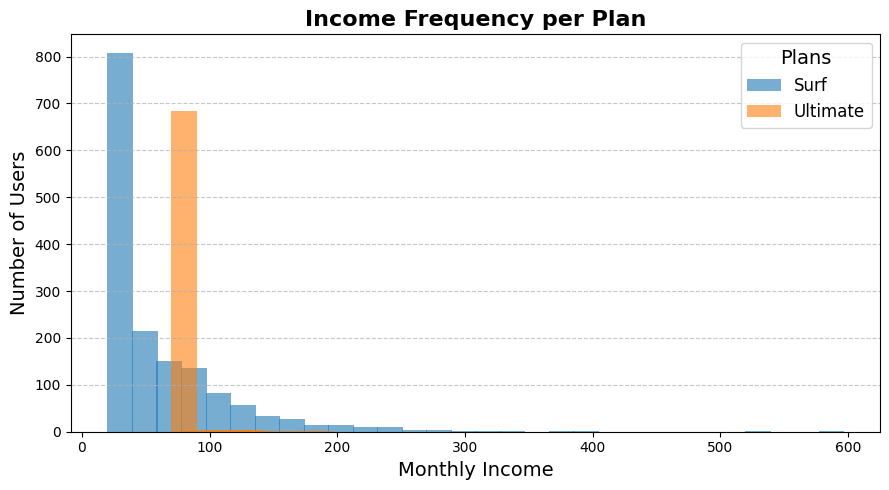

In [38]:
# Agrupando por 'plan_name', 'month' e 'user_id' para calcular a soma da coluna de receitas mensais
income_per_user = df_complete.groupby(['plan_name', 'month', 'user_id'])['monthly_income'].sum()
income_per_user = income_per_user.reset_index()
income_per_user = income_per_user[income_per_user['monthly_income'] > 0]

# filtrando os dados por planos
surf_income_per_user = income_per_user[income_per_user['plan_name'] == 'surf']
ultimate_income_per_user = income_per_user[income_per_user['plan_name'] == 'ultimate']

# Plotando os histogramas
surf_income_per_user['monthly_income'].plot(kind='hist', bins=30, alpha=0.6, width=20, figsize = [9, 5], color='#1f77b4', label='Surf Plan')
ultimate_income_per_user['monthly_income'].plot(kind='hist', bins=30, alpha=0.6, width=20, color='#ff7f0e', label='Ultimate Plan')

plt.title('Income Frequency per Plan', fontsize=16, fontweight='bold')
plt.xlabel('Monthly Income', fontsize=14)
plt.ylabel('Number of Users', fontsize=14)
plt.legend(['Surf', 'Ultimate'], title='Plans', fontsize=12, title_fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

In [39]:
# Calculando a média e a variação receita mensal
monthly_income_surf_variance = np.var(income_mean_by_plan['monthly_income_surf'])
monthly_income_ultimate_variance = np.var(income_mean_by_plan['monthly_income_ultimate'])

print('Receita média do plano surf:', income_mean_by_plan['monthly_income_surf'].mean())
print('Variância da receita do plano surf:', monthly_income_surf_variance)
print()
print('Receita média do plano ultimate:', income_mean_by_plan['monthly_income_ultimate'].mean())
print('Variância da receita do plano ultimate:', monthly_income_ultimate_variance)

Receita média do plano surf: 49.654664697007696
Variância da receita do plano surf: 179.63305431915126

Receita média do plano ultimate: 71.81254837071394
Variância da receita do plano ultimate: 1.2374140556790674


### CONCLUSÕES

- A receita média por usuário é maior no plano 'ultimate', porém analisando o gráfico de barras, é possível observar que esta diferença vem caindo ao longo dos meses, pois cada vez mais, os usuários do plano 'surf' estão utilizando minutos, mensagens e dados extras, aumentando assim suas contas mensais, enquanto os usuários do plano 'ultimate' não utilizam minutos e mensagens extras e raramente fazem uso de dados extras. Existe até mesmo uma tendência de que no futuro a receita média seja maior com os usuários do plano 'surf';  


- Analisando o histograma, podemos observar o relatado acima, pois os usuários do plano 'ultimate' tem uma frequência muito constante de despesa igual a 70 USD (preço do pacote), enquanto usuários do plano 'surf' variam muito mais, tendo uma maioria de usuários com despesa mensal média de 20 USD (preço do pacote), mas atingindo valores próximos de até 600USD devido uso de pacotes extras;  


- Analisando as médias e variâncias das receitas médias de cada plano, podemos verificar uma variação muito maior entre usuários do plano 'surf', conforme mencionado acima, pois a Variância da despesa do plano surf é igual a 179.63, enquanto que a variância da despesa do plano ultimate é de apenas 1.24.

## TESTE DE HIPÓTESES

### Testar a hipótese de que as receitas médias dos usuários dos planos são diferentes

* A hipotese nula diz que os planos não tem diferença estatística entre suas receitas médias.
* A hipótese alternativa nos diz que as receitas são diferentes entre os planos.

**O teste visa avaliar se as médias de duas populações são iguais entre si, portanto realizaremos um teste bicaudal**

In [40]:
# Definido alpha
alpha = 0.05

income_surf_mean =  income_mean_by_plan['monthly_income_surf']
income_ultimate_mean =  income_mean_by_plan['monthly_income_ultimate']

results = st.ttest_ind(income_surf_mean, income_ultimate_mean, equal_var = True)

print('valor_p:', results.pvalue)

# Se p-valor for menor que alpha, rejeitamos a hipótese nula
if results.pvalue < alpha:
    print('Rejeitamos a hipótese nula')
else:
    print('Não rejeitamos a hipótese nula')

valor_p: 1.7246741308689412e-05
Rejeitamos a hipótese nula


### Testar a hipótese de que a receita média de usuários de NY-NJ difere de usuários das demais regiões

* A hipotese nula diz que a receita média dos usuários da área de NY-NJ não se difere dos usuários das demais regiões,  

* A hipótese alternativa nos diz que a receita média dos usuários da área de NY-NJ ´diferente da dos usuários das demais regiões.

**O teste visa avaliar se as médias de duas populações são iguais entre si, portanto realizaremos um teste bicaudal**

In [41]:
# Definindo o valor de alpha
alpha = 0.05

# Filtrando o Df para obter os dados da região desejada, agrupando por plano e mês, e calculando a média
ny_nj = df_complete[df_complete['estado'] == 'NY-NJ-PA MSA']
ny_nj_income_mean = ny_nj.groupby(['plan_name', 'month'])['monthly_income'].mean()

# Filtrando o Df para obter os dados das outras regiões, agrupando por plano e mês, e calculando a média
other_states = df_complete[df_complete['estado'] != 'NY-NJ-PA MSA']
other_states_income_mean = other_states.groupby(['plan_name', 'month'])['monthly_income'].mean()

# Os meses de fevereiro e março tiveram valores ausentes, pois nestes meses não havia o plano na região. 
# Desta forma, foi necessário tratar os dados ausentes com o valor do plano (70) para que p-valor não fosse 'nan'. 
# Foi escolhido este valor, pois os meses sequentes (abril, maio e junho) também apresentaram este resultado
ny_nj_income_mean = ny_nj_income_mean.fillna(70) 


results_df_teste_ny_nj = st.ttest_ind(ny_nj_income_mean, other_states_income_mean)

print('valor_p:', results_df_teste_ny_nj.pvalue)

if results_df_teste_ny_nj.pvalue < alpha:
    print('Rejeitamos a hipótese nula')
else:
    print('Não rejeitamos a hipótese nula')

valor_p: 0.9194978989448326
Não rejeitamos a hipótese nula


## CONCLUSÃO GERAL

* Analisando os valores-p podemos inferir que as receitas são diferentes entre os planos. Como podemos observar nas análises anteriores, em média a receita do plano 'ultimate' é maior que a média da receita do plano 'surf' embora esta diferença tenha caído muito ao longo do ano, pois os usuários do plano 'surf' costumam consumir muito mais pacotes extras aumentando muito o custo mensal destes usuários, tanto que analisando o histograma de despesa por plano, podemos observar que as maiores despesas individuais são sempre de usuários do plano 'surf'.  


* Quando analisamos a região NY-NJ, não encontramos diferença significativa quando comparamos com a média de todos outros estados, pois o valor-p foi de 0.919, o que não nos permite rejeitar a hipótese nula (de que a receita média dos usuários da área de NY-NJ não se difere dos usuários das demais regiões).

<CENTER>
    
# Renan Rosental de Oliveira